## Develop an Embedding + CNN Model for Sentiment Analysis

Based on the prvious work in Keras_NLP7_MovieValidation

Previously downloaded and processed movie review data from IMDB. Code calls these functions, it prepares the positive and negative reviews from the training dataset. At the end of this process we have the processed reviews and the associated labels for each review.


In [58]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

In [40]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out tokens not in vocab
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(directory, vocab, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('data/txt_sentoken/neg', vocab, is_train)
    pos = process_docs('data/txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = array([0 for _ in range(len(neg))] + [1 for _ in range(len(pos))])
    return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [41]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load training data
train_docs, ytrain = load_clean_dataset(vocab, True)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

train_docs now contains cleaned and process movie reviews, ytrain contains label 0/1 for neg/pos review. 

These reviews are then mapped to integers using Tokeniser API

Now that the mapping of words to integers has been prepared, we can use it to encode the
reviews in the training dataset. We can do that by calling the texts to sequences() function
on the Tokenizer. We also need to ensure that all documents have the same length. This is a
requirement of Keras for efficient computation. Pad all reviews to the length of the longest review in the training dataset. First, we can find the longest review using the max() function on the training dataset and take its length.
We can then call the Keras function pad sequences() to pad the sequences to the maximum
length by adding 0 values on the end.


In [46]:
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# calculate the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)

Vocabulary size: 45242
Maximum length: 2365


Then use the maximum length as a parameter to a function to integer encode and
pad the sequences.

In [47]:
# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

Ready to define our neural network model. The model will use an Embedding
layer as the first hidden layer. The Embedding layer requires the specification of the vocabulary
size, the size of the real-valued vector space, and the maximum length of input documents. The
vocabulary size is the total number of words in our vocabulary, plus one for unknown words.
This could be the vocab set length or the size of the vocab within the tokenizer used to integer
encode the documents

Use a 100-dimensional vector space.  The maximum document length was calculated above in the max length variable
used during padding. The complete model definition is listed below including the Embedding
layer. We use a Convolutional Neural Network (CNN) as they have proven to be successful
at document classification problems. A conservative CNN configuration is used with 32 filters
(parallel fields for processing words) and a kernel size of 8 with a rectified linear (relu) activation
function.

Next, the 2D output from the CNN part of the model is flattened to one long 2D vector to
represent the features extracted by the CNN. The back-end of the model is a standard Multilayer
Perceptron layers to interpret the CNN features. The output layer uses a sigmoid activation
function to output a value between 0 and 1 for the negative and positive sentiment in the review

In [51]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='img/model2.png', show_shapes=True)
    return model

In [52]:
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
# define model
model = define_model(vocab_size, max_length)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2365, 100)         4524200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2358, 32)          25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1179, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 37728)             0         
_________________________________________________________________
dense_59 (Dense)             (None, 10)                377290    
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 11        
Total params: 4,927,133
Trainable params: 4,927,133
Non-trainable params: 0
_________________________________________________________________


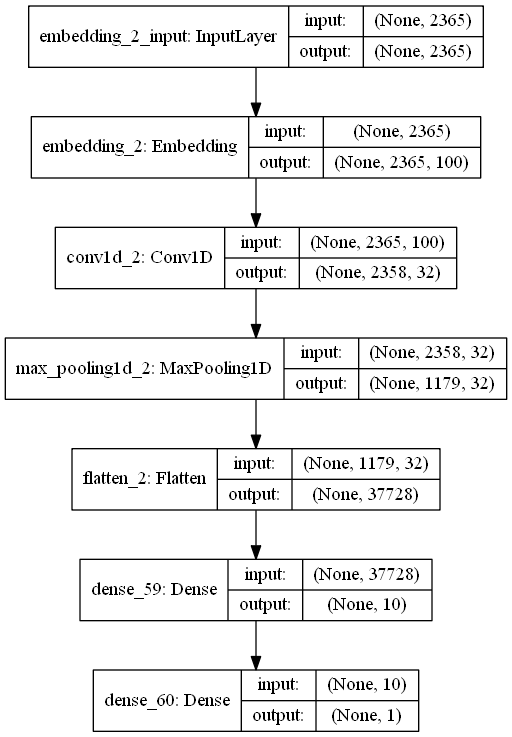

In [53]:
Image("img/model2.png",width = 400)

In [54]:
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
# save the model
model.save('model.h5')

Epoch 1/10
 - 4s - loss: 0.6903 - acc: 0.5161
Epoch 2/10
 - 1s - loss: 0.5961 - acc: 0.6717
Epoch 3/10
 - 1s - loss: 0.1979 - acc: 0.9239
Epoch 4/10
 - 1s - loss: 0.0214 - acc: 0.9972
Epoch 5/10
 - 1s - loss: 0.0051 - acc: 1.0000
Epoch 6/10
 - 1s - loss: 0.0025 - acc: 1.0000
Epoch 7/10
 - 1s - loss: 0.0015 - acc: 1.0000
Epoch 8/10
 - 1s - loss: 0.0011 - acc: 1.0000
Epoch 9/10
 - 1s - loss: 8.1919e-04 - acc: 1.0000
Epoch 10/10
 - 1s - loss: 6.3695e-04 - acc: 1.0000


### Evaluate the Model

Evaluate the trained model and use it to make predictions on new data.
First, we can use the built-in evaluate() function to estimate the skill of the model on both
the training and test dataset. This requires that we load and encode both the training and test
datasets.

In [56]:
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# calculate the maximum sequence length
max_length = max([len(s.split()) for s in train_docs])
print('Maximum length: %d' % max_length)
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
Xtest = encode_docs(tokenizer, max_length, test_docs)


Vocabulary size: 45242
Maximum length: 2365


Load and evaluate model on both train and test datasets

In [59]:
# load the model
model = load_model('model.h5')
# evaluate model on training dataset
_, acc = model.evaluate(Xtrain, ytrain, verbose=0)
print('Train Accuracy: %f' % (acc*100))
# evaluate model on test dataset
_, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))


Train Accuracy: 100.000000
Test Accuracy: 88.000000


In [61]:
len(train_docs)

1800

New data must then be prepared using the same text encoding and encoding schemes as was
used on the training dataset. Once prepared, a prediction can be made by calling the predict()
function on the model. The function below named predict sentiment() will encode and pad
a given movie review text and return a prediction in terms of both the percentage and a label.

In [62]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, max_length, model):
    # clean review
    line = clean_doc(review, vocab)
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [63]:
text = 'Everyone will enjoy this film. I love it, recommended!'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))


Review: [Everyone will enjoy this film. I love it, recommended!]
Sentiment: POSITIVE (57.285%)
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (61.305%)
